# Code Tutorial for Physical Attack on a white box model

___
## Contents
1. [Introduction](#introduction)
2. [Prequisites](#Prerequisites)
2. [Physical Attack Class](#Physical-Attack-Class)
3. [GUI Setup](#gui-build-with-ipywidget)
4. [Run Attack w/ GUI](#Run-attack-with-GUI)
5. [Test w/ Different Masks on STL10](#Test-different-masks-with-STL10-test-images)
6. [Real Physical Attack Examples](#Physical-attacks-on-real-world-examples)

## Introduction
### Why?
The disturbance has been produced without being restricted to a specific picture region using the techniques that have been demonstrated thus far in class. Furthermore, the other techniques produced the disturbance on the pictures without considering the printability of the colors. This will enable users to employ the perturbation in the real world by considering the printability of colors. Along with restricting the perturbation to specific regions of the image to further avoid recognition.

### How does it work in general?
It is easier than the FGSM, BIM, and PGD methods since we don't have to figure out the gradient of the input pixels. Our perturbation, $\delta$, will be defined as a variable whose values are optimized. In order to modify the components in $\delta$, the optimizer will first multiply some parts of $\delta$ by a mask. As a result, the disturbance only impacts particular regions of the picture.

Loss 1: The loss 1 includes how well the model is at predicting our desired target class.
- In a targeted attack, the "ground truth" label, that is passed to the loss function, is the desired target. If the loss is small, the model will predict the target class:

\begin{equation*}
\mathcal{L}_1 = crossentropy(\theta, x, T)
\end{equation*}

- In an untargeted attack, the true ground label is passed to the loss function. Therefore, a small loss indicates that the model makes the correct prediction. Since we want the model to predict anything but the true class, you need compute the inverse of the crossentropy value. To avoid division by zero, add a small number $\gamma$ to the denominator:
\begin{equation*}
\mathcal{L}_1 = \frac{1}{crossentropy(\theta, x, y) + \gamma}
\end{equation*}

Loss 2: The loss 2 is influenced by an error that is called printer error. The printer error measures how close each pixel value is to printable colors. Loss 2 will be small, if each pixel value is close to one of the pre-defined colors.

## Prequisites

### Imports

In [23]:
!gdown 1-07DCaJtJAlj1JdVMqtrob4d4Td7IuMw # Download white box model
!git clone https://github.com/Gikaeh/Adversial-Physical-Attacks.git # Import necessary files
!mv Adversial-Physical-Attacks/* .
!rm -rf Adversial-Physical-Attacks
!pip install -r requirements.txt

import os
import tensorflow as tf
import keras
import cv2
import numpy as np
import pickle
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import re
from tqdm.notebook import trange
from extra_keras_datasets import stl10

### Model Load
Uses Tensor Flow Keras library versus standalone Keras for better cohesion. Loads previously trained and finetuned VGG16 white box model for image recognition. This model was trained on 8000 images and tested on 5000 images from CIFAR10 dataset.

In [3]:
model = tf.keras.models.load_model("test.keras")

### Variables
Define Image dimensions and class list variables.

In [4]:
# class list of stl10
class_list = ["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]

# image sizes
w, h, d = 96, 96, 3

### Plotting images with pred. class & confidence value
Shows the images with the models predicted class label and confidence value.

In [5]:
def plot_images(images, columns, rows, title, model, targets=None, gt=None, class_list= ["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"], w=96, h=96,d=3, size=(15, 8), ae=False):
    fig=plt.figure(figsize=size)
    plt.suptitle(title, fontsize=16)
    columns = columns
    rows = rows
    for i in range(1, columns*rows +1):
        img = images[i-1]
        fig.add_subplot(rows, columns, i)
        pred = model.predict(images[i-1].reshape(1, w, h, d))
        pred_class = class_list[np.argmax(pred.flatten())]
        pred_class_conf_prob = max(pred.flatten())
        if targets is not None:
            pred_target_class = max(pred.flatten()*targets[i-1])
            plt.title(f"{pred_class} ({pred_class_conf_prob:.2f})\nTarget: {pred_target_class:.2f}")
        elif gt is not None:
            plt.title(f"{pred_class} ({pred_class_conf_prob:.2f})\nG.T.: {gt[i-1]}")
        else:
            plt.title(f"{pred_class} ({pred_class_conf_prob:.2f})")

        if ae:
            img = np.clip(img, 0, 1)

        plt.imshow(img)
    plt.show()

### Plotting images with mask over original
Shows the original image with the designated mask over it. Also displaying the predicted label and confidence value.

In [6]:
def plot_physical_adv(model, w, h, d, adv_images, target, save=True, name="test", attack_type="targeted", class_list=["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]):
    # Ensure input is iterable if single example
    if not isinstance(adv_images, (list, np.ndarray)):
        adv_images = [adv_images]

    for i, adv_image in enumerate(adv_images):
        # Convert tensor to numpy array if needed
        if tf.is_tensor(adv_image):
            adv_np = adv_image.numpy()
        else:
            adv_np = adv_image

        # Reshape to image dimensions
        img_array = adv_np.reshape((h, w, d))

        # Make prediction
        pred = model.predict(np.expand_dims(img_array, 0)).flatten()
        best = np.argmax(pred)
        target_conf = pred[np.argmax(target.flatten())]

        # Save image if requested
        if save:
            if not os.path.isdir("./generated_advs"):
                os.mkdir("./generated_advs")
            filename = f"./generated_advs/{name}_{class_list[best]}_{pred[best]:.2f}.jpg"
            plt.imsave(filename, img_array)

        # Create plot
        plt.imshow(img_array)
        if attack_type == "targeted":
            plt.title(f"Best: {class_list[best]} ({pred[best]:.2f})\nTarget: {target_conf:.2f}")
        else:
            plt.title(f"Best: {class_list[best]} ({pred[best]:.2f}\nG.T.: {target_conf:.2f})")
        plt.show()

### Model Evaluation
Evaluate white box model on set of nine images using the plot_images function mentioned above.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


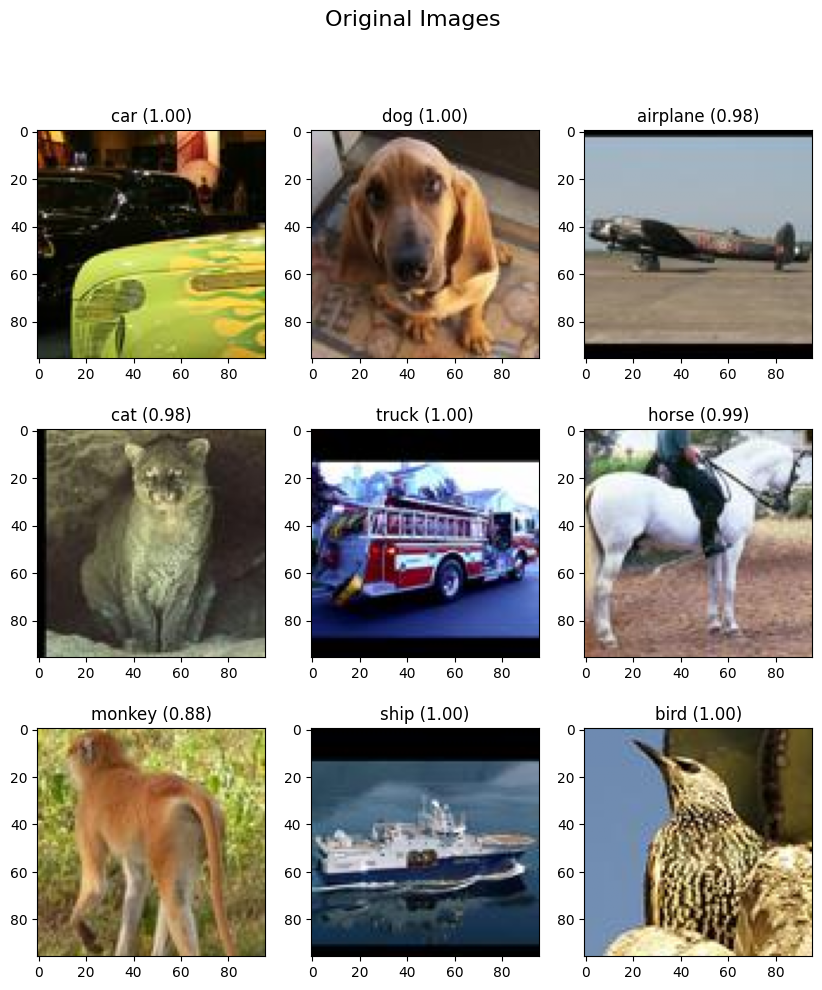

In [7]:
# Load attack images
org_images = []
for path in os.listdir("./imgs_gui/"):
    img = plt.imread("./imgs_gui/" + path)
    org_images.append(img/255.)
org_images = np.array(org_images)

# Evaluate model
plot_images(org_images, 3, 3, title="Original Images", model=model, size=(10, 11))


## Physical Attack Class

1. Initialize a variable $\delta$ (noise) with random values and load an input image
2. Multiply noise with a mask that only contains areas with ones and zeros. The ones in the mask indicate the changeable elements in $\delta$: $mask * noise$
3. Compute the inverse of the mask and multiply it with the current image: $(1 - mask) * img$
4. Add the masked image to the masked pertubation: $[mask * noise] + [(1 - mask) * img]$
5. Feed the image to the classification network and get the prediction
6. Calculate the loss
7. Use Gradient Descent with the optimizer adam to change the elements of the noise to minimize loss
8. Return to step 2 or stop the training if the number of epochs are reached

These steps can be shown as:
<figure style="text-align:center">
    <p></p>
  <img src="charts/physical_process.png " width="50%">
     <p></p>
  <figcaption style="font-family:courier;">Physical Attack Process</figcaption>
</figure>

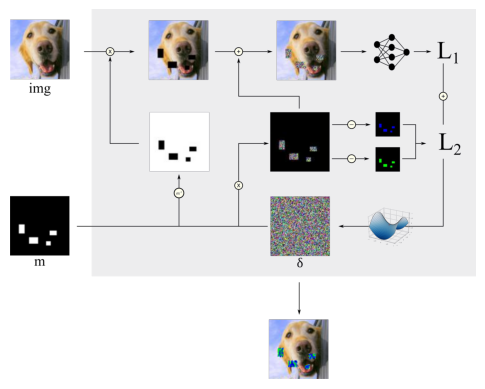

In [28]:
img = mpimg.imread('charts/physical_process.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [14]:
class PhysicalAttack():
    def __init__(self, img_rows, img_cols, depth, n_classes, noisy_input_clip_min, noisy_input_clip_max, attack_lambda, print_lambda, lr, model, targeted):
        # Input dimensions
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.depth = depth # Color channels
        self.n_classes = n_classes # number of output classes

        # Clipping bounds
        self.noisy_input_clip_min = noisy_input_clip_min
        self.noisy_input_clip_max = noisy_input_clip_max

        # Loss weights
        self.attack_lambda = attack_lambda # Weight for regularization loss
        self.print_lambda = print_lambda # Weight for printable color loss

        # Optimization
        self.lr = lr
        self.opt = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-08)

        # Model and mode
        self.model = model
        self.targeted = targeted # Targeted: Specific incorrect prediction; Untargeted: Any missclassification

        # Noise variable (trainable)
        self.noise = tf.Variable(
            tf.random.uniform([img_rows, img_cols, depth], 0.0, 1.0), # Random noise with a min of 0 and max of 1
            trainable=True, # Optimized noise during training
            name='noise'
        )

        # Define input signatures for tf.function
        self.train_step = tf.function(
            self._train_step, # Compile training step during class initialization
            input_signature=[
                tf.TensorSpec(shape=(None, img_rows, img_cols, depth), dtype=tf.float32), # Input Image
                tf.TensorSpec(shape=(None, n_classes), dtype=tf.float32), # Labels
                tf.TensorSpec(shape=(img_rows, img_cols, depth), dtype=tf.float32), # Noise mask
                tf.TensorSpec(shape=(None, img_rows, img_cols, depth), dtype=tf.float32), # Printable colors
                tf.TensorSpec(shape=(), dtype=tf.float32), # Min clip
                tf.TensorSpec(shape=(), dtype=tf.float32), # Max clip
                tf.TensorSpec(shape=(), dtype=tf.float32), # Attack lamba
                tf.TensorSpec(shape=(), dtype=tf.float32) # Print lambda
            ]
        )

    def _l1_norm(self, tensor):
        # Computes L1 regularization loss
        return tf.reduce_sum(tf.abs(tensor))

    def _train_step(self, image_in, attack_target, noise_mask, printable_colors, noisy_input_clip_min, noisy_input_clip_max, attack_lambda, print_lambda):
      with tf.GradientTape() as tape:
          # Forward pass
          noise_mul = tf.multiply(noise_mask, self.noise) # Apply mask to noise
          noise_mul_clip = tf.clip_by_value(noise_mul, noisy_input_clip_min, noisy_input_clip_max) # Clip noise
          inverse_masks = 1.0 - noise_mask
          # Combine image and noise
          noise_inputs = tf.clip_by_value(
              tf.add(image_in * inverse_masks, noise_mul), # Add mask img to mask perturbation
              noisy_input_clip_min, noisy_input_clip_max
          )

          # Model predictions
          adv_pred = self.model(noise_inputs)

          # Regularization loss
          reg_loss = self._l1_norm(noise_mul)

          # Classification loss
          loss_f = tf.keras.losses.categorical_crossentropy(attack_target, adv_pred, from_logits=False)
          loss = tf.cond(
              tf.logical_not(self.targeted), # If untargeted, minimize confidence in true class
              lambda: 1/(loss_f + 1e-3), # Inverse loss for untargeted 1/(CE+(1e-3))
              lambda: loss_f # Direct loss for targeted
          )

          # Printable color loss
          printab_diff = tf.math.squared_difference(noise_mul, printable_colors * noise_mask) #Difference from printable colors
          printer_error = tf.reduce_sum(tf.reduce_prod(tf.reduce_sum(printab_diff, 3), 0))

          # Total adversarial loss
          adv_loss = loss + attack_lambda * reg_loss + print_lambda * printer_error

      # Gradient calculation & application
      grads = tape.gradient(adv_loss, [self.noise])
      self.opt.apply_gradients(zip(grads, [self.noise]))

      return [adv_loss, noise_inputs, loss, reg_loss, printer_error, noise_mul_clip, loss_f]

    def generate(self, n_epochs, img, target, mask, print_colors, verbose=True):
      # Initialize noise
      self.noise.assign(tf.random.uniform(self.noise.shape, 0.0, 1.0))

      for i in (trange(n_epochs) if verbose else range(n_epochs)):
          outputs = self.train_step(
              img, target, mask, print_colors,
              self.noisy_input_clip_min, self.noisy_input_clip_max,
              self.attack_lambda, self.print_lambda
          )

          if verbose and (i % 200 == 0):
              adv_loss, _, loss_cat, _, loss_print, clipped_noise, _ = outputs
              print(f"\nEpoch {i}: Total Loss: {float(adv_loss):.4f}, "
                    f"Classification Loss: {float(loss_cat):.4f}, "
                    f"Print Loss: {float(loss_print):.4f}")
              plt.imshow(clipped_noise.numpy().reshape(self.img_rows, self.img_cols, 3))
              plt.show()

      return outputs[1]  # Return noise_inputs

## Gui Build with Ipywidget

### Helper functions
Contains Listener functions for the GUI display along with a read function for the images and a color load function for the images.

In [15]:
def row(descr):
    # This is used to create images and checkboxes next to each other
    return widgets.Checkbox(description=descr, value=False, indent=False)


def img_checkbox_listener(change):
    # This method manually allows only one checkbox to be checked.
    curr_descr = change["owner"].description
    for rb in rbs_imgs:
        if rb.description != curr_descr:
            rb.value=False


def printer_loss_listener(change):
    #This listener enables or disbables the printer hyperparameters if we don't want to include printable color
    if change["new"] == "Enable":
        colors.disabled=False
        print_lambda_slider.disabled = False
    elif change["new"] == "Disable":
        colors.disabled=True
        print_lambda_slider.disabled = True


def attack_type_listener(change):
    # This listener enables or disbables the target selection
    if change["new"] == "untargeted":
        targets.disabled=True
    elif change["new"] == "targeted":
        targets.disabled=False


def _read_img(descr_list, is_mask, w, h, d):
    # This method is used to read in attack images or masks
    pattern = re.compile(r"'(.*?)'")# Descriptions look like <img src='...'>. We extract the image path

    # Check if image is a mask
    if is_mask:
        masks = []
        # Load all masks
        for m in descr_list:
            path = re.findall(pattern, m)[0]
            mask = cv2.imread(path)
            mask = mask/255.
            masks.append(mask)
        return masks
    else:
        # Load attack image
        path = re.findall(pattern, descr_list[0])[0]
        img = plt.imread(path)
        img = img/255.
        img = img.reshape(1, w, h, d)
        return img, path


def _load_color_list(colors_str, w, h):
    # Load the printable colors and convert them into images with w, h, d.
    # For each color an image is generated that only contains pixel with that color
    p = []

    # Iterate over each color in the string
    for c in colors_str.split("\n"):
        p.append(c.split(","))

    # Generate w, h, d images
    p = map(lambda x: [[x for _ in range(w)] for __ in range(h)], p)
    p = np.array(list(p)).astype(float)

    return p

### GUI Elements
Builds the rows of the first 2 selection tabs that display the descriptions of the Original images and different mask for selection. It also creates all the hyperameter slider and selection options.

In [16]:
# We set 9 images fix from stl10 dataset
rbs_imgs = (row("<img src='imgs_gui/airplane.jpg'>"), row("<img src='imgs_gui/bird.jpg'>"),
            row("<img src='imgs_gui/car.jpg'>"), row("<img src='imgs_gui/cat.jpg'>"),
            row("<img src='imgs_gui/deer.jpg'>"), row("<img src='imgs_gui/dog.jpg'>"),
            row("<img src='imgs_gui/horse.jpg'>"), row("<img src='imgs_gui/monkey.jpg'>"),
            row("<img src='imgs_gui/ship.jpg'>"))
# Creates horizontal rows of check boxs for selection of images
radio_buttons_imgs = widgets.HBox([*rbs_imgs], layout=Layout(height="300px", width='100%', display='inline-flex',flex_flow='row wrap'))
for rb in rbs_imgs:
    rb.observe(img_checkbox_listener)


# Create checkboxes for the masks
rbs = ( row("<img src='masks/mask1.png'>"), row("<img src='masks/mask2.png'>"),
        row("<img src='masks/mask3.png'>"), row("<img src='masks/mask4.png'>"),
        row("<img src='masks/mask5.png'>"), row("<img src='masks/mask6.png'>"))
# Creates horizontal rows of check boxs for selection of masks
radio_buttons = widgets.HBox([*rbs], layout=Layout(height="300px", width='100%', display='inline-flex',flex_flow='row wrap'))


# Create widgets for hyperparametrs
# Width of image (currently fixed to stl10)
w_input = widgets.Text(
    value='96',
    description='Input width:',
    style ={'description_width': '150px'},
    disabled=True
)
# Height of image (currently fixed to stl10)
h_input = widgets.Text(
    value='96',
    description='Input height:',
    style ={'description_width': '150px'},
    disabled=True
)
# Depth of image (currently fixed to stl10)
d_input = widgets.Text(
    value='3',
    description='Input depth:',
    style ={'description_width': '150px'},
    disabled=True
)
input_dims = HBox([w_input, h_input, d_input])

# Number of classes in stl10
n_classes = widgets.Text(
    value='10',
    description='Number of classes:',
    style ={'description_width': '150px'},
    disabled=True
)

# Number of epochs slider
n_epochs = widgets.IntSlider(
    value=1000,
    min=100, max=2000, step=100,
    description='Number Epochs:',
    style ={'description_width': '150px', 'width':'100%'}
)

# Printer loss slider
print_lambda_slider = widgets.FloatSlider(
    value=0.01,
    min=0, max=1, step=0.01,
    description='Printer Lambda:',
    style ={'description_width': '150px', 'width':'100%'}
)

# Learning rate slider
lr = widgets.FloatSlider(
    value=0.1,
    min=0.01, max=0.1, step=0.01,
    description='Learning Rate:',
    style ={'description_width': '150px'}
)

# Printable colors text area
colors = widgets.Textarea(
    value='0.01, 0.01, 0.01\n1, 1, 1',
    description='Color List:',
    style ={'description_width': '150px'}
)

# Attack type radio button
attack_type = widgets.RadioButtons(
    options=['targeted', 'untargeted'],
    description='Attack type:',
    disabled=False,
    style ={'description_width': '150px'}
)
attack_type.observe(attack_type_listener)

# Targets radio buttons
targets = widgets.RadioButtons(
    options=class_list,
    description="Targets",
    disabled=False,
    style ={'description_width': '150px'}
)

# Print attack boolean radio button
printer_attack = widgets.RadioButtons(
    options=['Enable', 'Disable'],
    description='Print Loss',
    disabled=False,
    style ={'description_width': '150px'}
)

printer_attack.observe(printer_loss_listener)

### Attack button listener
This functions is the beginning of the attack for the GUI when the "run attack button" is pressed. It checks multiple conditional statements for image and mask selection and loads the white box model. The hyperparameters are taken from the GUI selection and passed to the instatiation of the Physical Attack class for noise generation.

In [17]:
def attack_button_listener(btn_object):
    print("Starting the attack...")

    # Get attack image description
    selected_imgs = []
    for i, item in enumerate(rbs_imgs):
        if item.value:
            selected_imgs.append(item.description)

    # User needs to select one image
    if len(selected_imgs) == 0:
        print("Please select at least one image")
    else:
        # Read in image
        img, path = _read_img(selected_imgs, False, int(w_input.value), int(h_input.value), int(d_input.value))

        # Seperate true label from file path
        path = path.split("/")[1]
        true_label = path.split(".")[0]

        # Get masks descriptions
        selected_masks = []
        for i, item in enumerate(rbs):
            if item.value:
                selected_masks.append(item.description)

        # User needs to select at least one mask
        if len(selected_masks) == 0:
            print("Please select at least one mask")
        else:
            # Read in mask
            masks = _read_img(selected_masks, True, int(w_input.value), int(h_input.value), int(d_input.value))

            # Generate target vectors
            target = np.zeros((1, len(class_list)))

            # If targeted attack, then take the user defined target
            if attack_type.value == "targeted":
                target[0][class_list.index(targets.value)] = 1
            # Else take the ground truth as target
            else:
                target[0][class_list.index(true_label)] = 1

            # This is our white box model
            model = tf.keras.models.load_model("test.keras")

            # Load the printable colors
            p = _load_color_list(colors.value, int(w_input.value), int(h_input.value))

            # check if we want to include colors inside the attack
            print_lambda = 0
            if printer_attack.value == "Enable":
                print_lambda =  print_lambda_slider.value

            # Instatiate the PhysicalAttack class and set parameter
            attack = PhysicalAttack(img_rows=int(h_input.value),
                                    img_cols=int(w_input.value),
                                    depth=int(d_input.value),
                                    n_classes=int(n_classes.value),
                                    noisy_input_clip_min = 0,
                                    noisy_input_clip_max = 1,
                                    attack_lambda = 0, # Attack lambda is set to zero, because we don't care about how much we see the noise
                                    print_lambda = float(print_lambda),
                                    lr = float(lr.value),
                                    model=model,
                                    targeted = attack_type.value == "targeted")

            # Container for generated images
            adv_images = []
            for i, m in enumerate(masks):
                print(f"Mask {i+1}", "#"*20)
                # Do the attack of n_epochs for each mask
                adv_images.append(attack.generate(img=img,
                                            n_epochs=int(n_epochs.value),
                                            target=target,
                                            mask=m,
                                            print_colors=p,
                                            verbose=1))
            # Plot all generated images
            plot_physical_adv(model, int(w_input.value), int(h_input.value), int(d_input.value),
                              adv_images, target, save=True, name=true_label, attack_type=attack_type.value)

### "Run Attack" button GUI element creation

In [18]:
# Create attack button and listen to it with the above function
button = widgets.Button(
    description='Run Attack',
)
button.on_click(attack_button_listener)

## Run attack with GUI

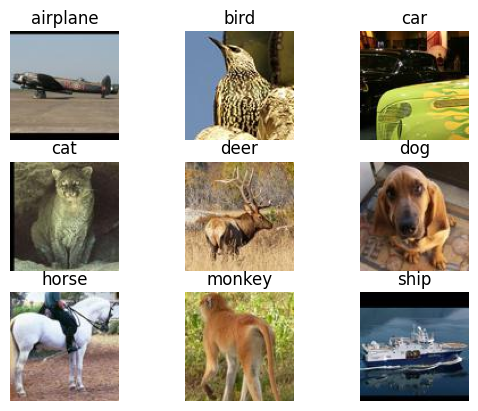

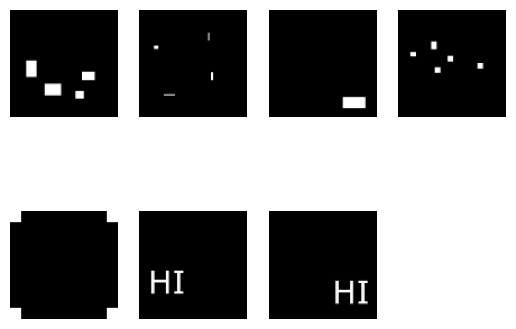

In [51]:
show_imgs = ['imgs_gui/airplane.jpg', 'imgs_gui/bird.jpg', 'imgs_gui/car.jpg', 'imgs_gui/cat.jpg',
            'imgs_gui/deer.jpg', 'imgs_gui/dog.jpg', 'imgs_gui/horse.jpg', 'imgs_gui/monkey.jpg',
            'imgs_gui/ship.jpg']
for i, img in enumerate(show_imgs):
    plt.subplot(3, 3, i+1)
    img = mpimg.imread(img)
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.title(class_list[i])
plt.show()

for i in range(1, 8):
  plt.subplot(2, 4, i)
  img = mpimg.imread(f'masks/mask{i}.png')
  imgplot = plt.imshow(img)
  plt.axis('off')
plt.show()

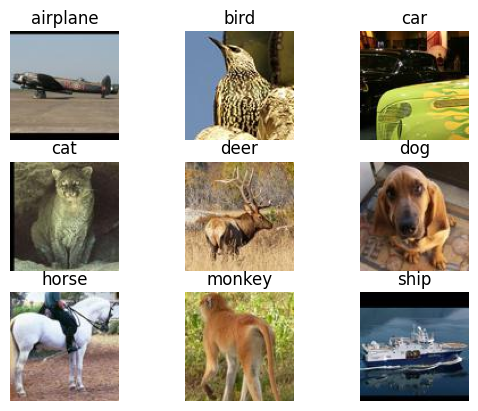

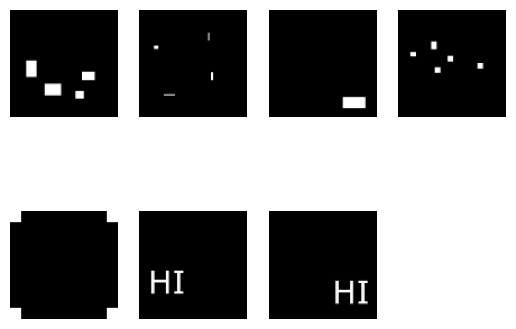

In [50]:
# build gui
tab_rb_imgs = VBox(children=[radio_buttons_imgs])
tab_rb = VBox(children=[radio_buttons])
tab_hp = VBox(children=[input_dims,

                      attack_type,
                        targets,
                        n_epochs,
                        lr,
                        printer_attack,
                        colors,
                       print_lambda_slider

                       ])

gui = widgets.Tab(children=[ tab_rb_imgs, tab_rb, tab_hp])
gui.set_title(0, 'Choose Image')
gui.set_title(1, 'Choose Masks')
gui.set_title(2, 'Hyperparameter')
VBox(children=[gui, button])

## Test different masks with STL10 test images

### Load STL10 dataset
Defines STL10 classes along with the pre-determined image dimensions. Splits the data between train and test sets in order train the different masks noise and test them on different images.

In [40]:
# Define stl10 class list and preprocess dataset
class_list = ["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]
num_classes = 10

# Define width, height and dimension of images
w, h, d = 96, 96, 3

# The data, split between train and test sets:
(x_test, y_test), (x_train, y_train)= stl10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
# Stl10 datasets starts with class 1, not 0
y_train = keras.utils.to_categorical(y_train-1, num_classes)
y_test = keras.utils.to_categorical(y_test-1, num_classes)

# Scale data between 0 and 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

2851452331/2851452331 ━━━━━━━━━━━━━━━━━━━━ 683s 0us/step


x_train shape: (8000, 96, 96, 3)
8000 train samples
5000 test samples


### Run attack on STL10 images
The creation of adversarial images for numerous images with multiple masks will take a long time so the number_of_images should be changed to reflect amount of time to spend on this section. There is already a saved dump of 100 images (Uses 1st 3 masks) in the pickle_dumps folder for use.

Can select the number of images to create the adversarial counterparts for and select what masks to use for adversarial counterparts.

In [43]:
# Number of images included in the validation
number_of_images = 100

# Instatiate attack class
attack = PhysicalAttack(img_rows=96,
                        img_cols=96,
                        depth=3,
                        n_classes=10,
                        noisy_input_clip_min = 0,
                        noisy_input_clip_max = 1,
                        attack_lambda = 0,
                        print_lambda = 0,
                        lr = 0.1,
                        model=model,
                        targeted = False)

# Load the masks
masks = []
mask_paths = ["masks/mask1.png", "masks/mask2.png", "masks/mask3.png"]
for m_path in mask_paths:
    mask = cv2.imread(m_path)
    mask = mask/255
    masks.append(mask)

Creates and save a pickle file for later use. If a pickle dump is already made for the number images uses that instead. Also runs a evaluation on the base model for the loaded 2000 test images.

In [44]:
# Attack the Images
if not os.path.isfile(f"pickle_dumps/adv_on_{number_of_images}.p"):
    if not os.path.isdir(f"pickle_dumps"):
        os.mkdir("pickle_dumps")
    # Storage for all adv images
    all_advs = []
    # Dummy colors
    with tf.device('/GPU:0'):
        p = _load_color_list("1, 1, 1", int(w_input.value), int(h_input.value))
        for i in trange(len(x_test[:number_of_images])):
            t_image = x_test[i]
            adv_images = []
            for j, m in enumerate(masks):
                # Do the attack of n_epochs for each mask
                adv_images.append(attack.generate(img=t_image.reshape(1, 96, 96, 3),
                                            n_epochs=400,
                                            target=y_test[i:i+1],
                                            mask=m,
                                            print_colors=p,
                                            verbose=0))
            all_advs.append(adv_images)

        # dump the results
        all_advs = np.array(all_advs)
        pickle.dump( all_advs, open( f"pickle_dumps/adv_on_{number_of_images}.p", "wb" ))
        print(f"Dump new adversarial images")
else:
    all_advs = pickle.load(open( f"pickle_dumps/adv_on_{number_of_images}.p", "rb" ))
    print("Load existing dump of adversarial images")

# Evaluate base model on the 2000 test images
print(f"Baseline of first {number_of_images} images: ", model.evaluate(x_test[:number_of_images], y_test[:number_of_images])[1])

Load existing dump of adversarial images
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.8033 - loss: 0.7475
Baseline of first 100 images:  0.800000011920929


### Success rate of the mask
Model predicts the class label for the adversarial images using the different mask and outputs the success rate as a percentage with higher being the percentage of the model being incorrect.

In [45]:
print(all_advs.shape)

# First extract images per mask and do reshape
all_advs = np.array(all_advs)
first_masks = all_advs[:, 0].reshape(-1, 96, 96, 3)
second_masks = all_advs[:, 1].reshape(-1, 96, 96, 3)
third_masks = all_advs[:, 2].reshape(-1, 96, 96, 3)

# Check model acc, success rate is 1-model acc
print("Succes rate of mask 1: ", 1- model.evaluate(first_masks, y_test[:number_of_images])[1])
print("Succes rate of mask 2: ", 1- model.evaluate(second_masks, y_test[:number_of_images])[1])
print("Succes rate of mask 3: ", 1- model.evaluate(third_masks, y_test[:number_of_images])[1])

(100, 3, 1, 96, 96, 3)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.0132 - loss: 7.9754
Succes rate of mask 1:  0.9800000004470348
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4484 - loss: 2.1553
Succes rate of mask 2:  0.5300000011920929
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4116 - loss: 2.7366
Succes rate of mask 3:  0.5699999928474426


### Plot examples
Display 10 adversarial images of each masks

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


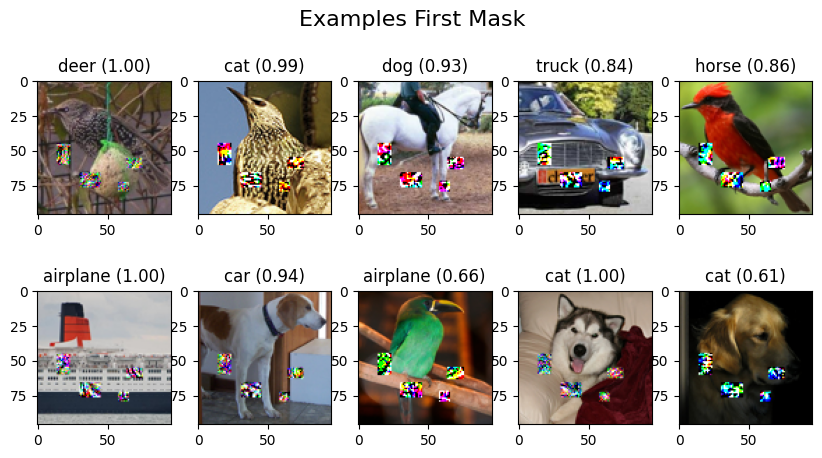

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


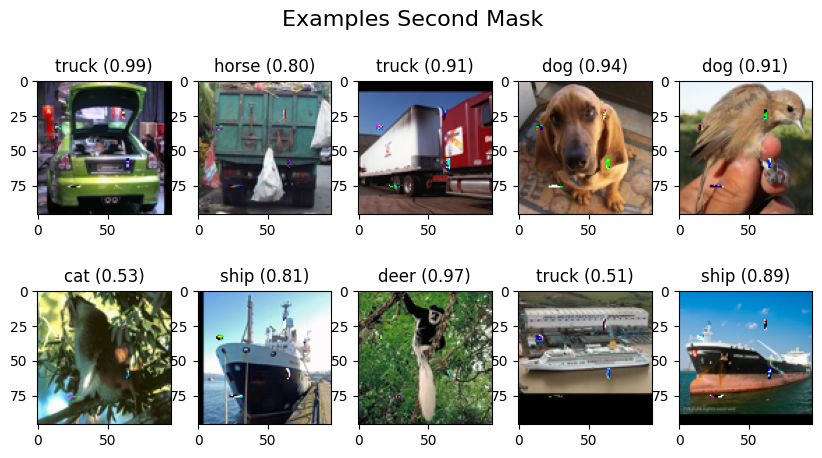

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


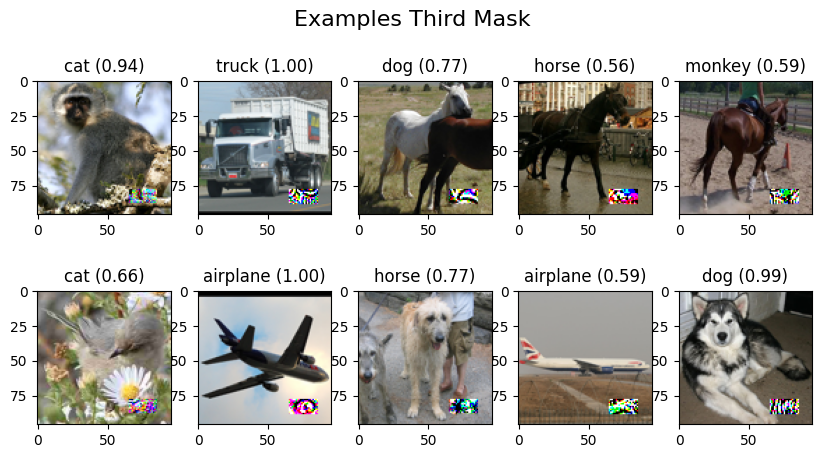

In [46]:
plot_images(first_masks[20:30], 5, 2, title="Examples First Mask", model=model, size=(10, 5))
plot_images(second_masks[60:70], 5, 2, title="Examples Second Mask", model=model, size=(10, 5))
plot_images(third_masks[90:100], 5, 2, title="Examples Third Mask", model=model, size=(10, 5))

## Physical attacks on real world examples
This section will take the noise created for specific images and replicate them as best as it can on real world versions of the images to see how the attacks compare. This is to test the possible changes in angles and lighting of the photos.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


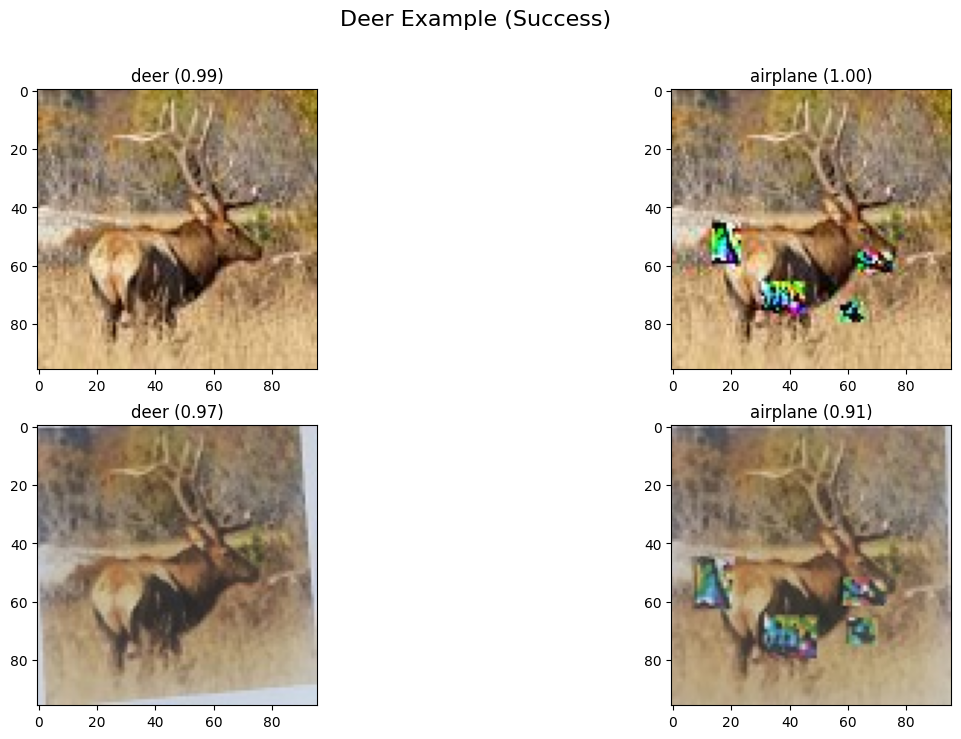

In [47]:
# Original digital image
img_org = plt.imread("imgs_adv/deer.jpg")
img_org = img_org/255.

# Original attack image
attack_org = plt.imread("imgs_adv/deer_airplane.jpg")
attack_org = attack_org/255.

# Photo original image
img_photo = plt.imread("imgs_adv/deer_org.jpg")
img_photo = img_photo/255.


# Photo attack image
attack_photo = plt.imread("imgs_adv/deer_adv.jpg")
attack_photo = attack_photo/255.


plot_images(np.array([img_org, attack_org, img_photo, attack_photo]), columns=2, rows=2, model=model, title="Deer Example (Success)", size=(15, 8))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


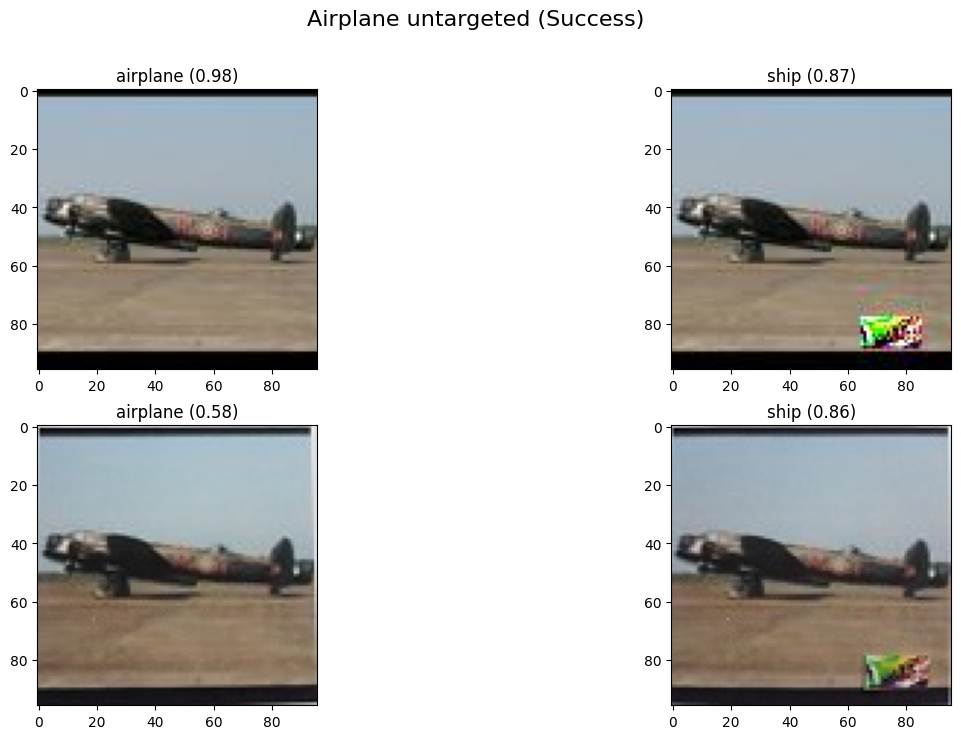

In [48]:
# Original digital image
img_org = plt.imread("imgs_adv/airplane.jpg")
img_org = img_org/255.

# Original attack image
attack_org = plt.imread("imgs_adv/airplane_ship.jpg")
attack_org = attack_org/255.

# Photo original image
img_photo = plt.imread("imgs_adv/airplane_org.jpg")
img_photo = img_photo/255.


# Photo attack image
attack_photo = plt.imread("imgs_adv/airplane_adv_ship.jpg")
attack_photo = attack_photo/255.


plot_images(np.array([img_org, attack_org, img_photo, attack_photo]), columns=2, rows=2, model=model, title="Airplane untargeted (Success)", size=(15, 8))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


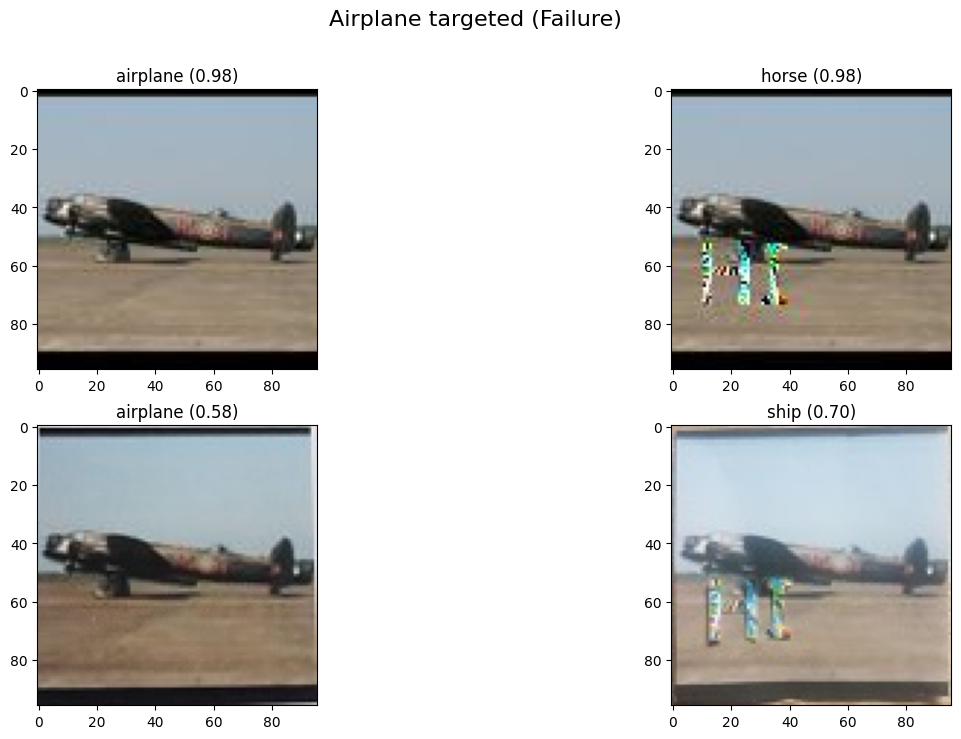

In [49]:
# Original digital image
img_org = plt.imread("imgs_adv/airplane.jpg")
img_org = img_org/255.

# Original attack image
attack_org = plt.imread("imgs_adv/airplane_horse.jpg")
attack_org = attack_org/255.

# Photo original image
img_photo = plt.imread("imgs_adv/airplane_org.jpg")
img_photo = img_photo/255.


# Photo attack image
attack_photo = plt.imread("imgs_adv/airplane_adv_horse.jpg")
attack_photo = attack_photo/255.


plot_images(np.array([img_org, attack_org, img_photo, attack_photo]), columns=2, rows=2, model=model, title="Airplane targeted (Failure)", size=(15, 8))

___
## Sources
[1] [Robust Physical-World Attacks on Machine Learning Models](https://arxiv.org/abs/1707.08945)  
[2] [Accessorize to a Crime: Real and Stealthy Attacks on
State-of-the-Art Face Recognition](https://www.cs.cmu.edu/~sbhagava/papers/face-rec-ccs16.pdf)  
[3] [Adam: A method for stochastic optimization](https://arxiv.org/abs/1412.6980)  
[4] [Deep Learning, S.82.86](http://www.deeplearningbook.org)  
[5] [GTRSB](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)  
[6] [ImageNet-trained CNNs are biased towards texture](https://openreview.net/forum?id=Bygh9j09KX)  
[7] [One Pixel Attack for Fooling
Deep Neural Networks](https://arxiv.org/pdf/1710.08864.pdf)  
